In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

#reads IRI and Dist files.

IRI_filename="ABPO_2009.txt" # be sure of deleting all other non-numeric values before first section
DIST_filename="Dst_2000_2023.txt" # it is already cleaned before processing
datafolder="data\\"

year=IRI_filename[IRI_filename.index("_")+1:IRI_filename.index(".")]
location=IRI_filename[:IRI_filename.index("_")]
print(year,location)
date_start = pd.to_datetime(year+'-01-01')
date_end = pd.to_datetime(year+'-12-31')
hour_steps_for_height=39 #39 is the number of different heights
column_names=[]  
 
with open(datafolder+IRI_filename) as file:
    for line in file.readlines()[1:59]:
       column_names.append(line[line.find(' ')+1:].strip().replace(" ", ""))

    
df_IRI=pd.read_csv(datafolder+IRI_filename, skiprows=61,header=None,delim_whitespace=True)
df_IRI.columns=column_names

df_DIST=pd.read_csv(datafolder+DIST_filename,skiprows=17)

df_DIST['DATE']=pd.to_datetime(df_DIST['DATE'])

mask_for_24h_format = (df_DIST['TIME'] == '00:00:00.000')
df_DIST.loc[mask_for_24h_format,'TIME'] = df_DIST.loc[mask_for_24h_format,'TIME'].replace('00:00:00.000','24:00:00.000',regex=True)
df_DIST.loc[mask_for_24h_format,'DATE'] = df_DIST.loc[mask_for_24h_format,'DATE']- timedelta(days=1)
df_DIST.loc[mask_for_24h_format,'DOY'] = df_DIST.loc[mask_for_24h_format,'DOY']-1

df_DIST=df_DIST.loc[(df_DIST['DATE'] >= date_start) & (df_DIST['DATE'] <= date_end)]
df_DIST.reset_index(drop=True, inplace=True)


print("IRI: ",df_IRI.shape)
print("DIST: ",df_DIST.shape, "Matched Len: ", len(df_DIST)*hour_steps_for_height) #365x24 row

if(len(df_IRI)<len(df_DIST)*hour_steps_for_height):   
    print("IRI has missing data for some hours. Syncronize!!")


#deleting some values from df_dist in order to syncronize both dataframe
sync_i=0
while sync_i < len(df_IRI):
    if int(df_IRI["Hour"][sync_i]) != int(df_DIST["TIME"][sync_i/hour_steps_for_height][0:2]):
       df_DIST.drop(sync_i/hour_steps_for_height, axis=0, inplace=True)
       df_DIST=df_DIST.reset_index(drop=True)
       continue
    sync_i+=hour_steps_for_height

if(len(df_IRI)== len(df_DIST)*hour_steps_for_height):
    print("syncronized") 

# print(df_IRI.shape)
# print(df_DIST.shape) #365x24 row
# for i in range(0,len(df_IRI),hour_steps_for_height):
#     print(df_IRI["Hour"][i],df_DIST["TIME"][i/hour_steps_for_height])  


2009 ABPO
IRI:  (341406, 58)
DIST:  (8760, 4) Matched Len:  341640
IRI has missing data for some hours. Syncronize!!
syncronized


In [9]:
#the columns we use for generating new dataset.Season information is not included

dates=df_IRI.apply(lambda row: '-'.join([str(int(row['Year'])), str(int(row['Month'])),str(int(row['Day']))]), axis=1).to_numpy()
hours=df_IRI["Hour"].to_numpy()
heights=df_IRI["Height,km"].to_numpy()
solar_zenith_angles=df_IRI["Solar_zenith_angle,degree"].to_numpy()
days_of_year= df_IRI["DOY"].to_numpy()
declination=df_IRI["Declination,degree"].to_numpy()
inclination=df_IRI["Dip,degree"].to_numpy()
latitude=df_IRI["Latitude,degree"].to_numpy()
longitude=df_IRI["Longitude,degree"].to_numpy()
ap_3h=df_IRI["3-h_ap"].to_numpy()
dsts=df_DIST["DST"].to_numpy()
kps=df_IRI["3-h_kp"].to_numpy()
foF2=df_IRI["foF2,MHz"].to_numpy()

In [10]:

hours_sin=np.sin(2*np.pi*hours/24) #in radian
hours_cos=np.cos(2*np.pi*hours/24) #in radian

solar_zenith_angles_sin=np.sin(2*np.pi*np.deg2rad(solar_zenith_angles)/360) #in radian (it  was originally degree)
solar_zenith_angles_cos=np.cos(2*np.pi*np.deg2rad(solar_zenith_angles)/360) #in radian

days_of_year_sin=np.sin(2*np.pi*days_of_year/360) #in radian
days_of_year_cos=np.cos(2*np.pi*days_of_year/360) #in radian

solar_activity_constant=np.full((len(df_IRI),),10.7) #it is constant, calculated as 10.7 cm.

#Geomagnetic Activity-->dst,kp,ap
ap_X=np.array([])          # calculated w.r.t formula in the article.
dst_t=np.array([])       # calculated w.r.t ap_X formula.
delta_kp_regressed=np.array([]) # calculated w.r.t formula in the comment below

####################################################################################
X=0.8   
past_steps=11
ap_start_index=past_steps*hour_steps_for_height # starting point to use previous values

for ap3hstep in range(ap_start_index,len(hours),hour_steps_for_height):
    ap_elem=0

    for step in range(past_steps,-1,-1):
        ap_elem+=(ap_3h[ap3hstep-hour_steps_for_height*step]*X**step) #ap_x calculation with respect to last 33h + current time

    ap_X=np.append(ap_X,np.repeat((1-X)*ap_elem,hour_steps_for_height)) # repeating for heights
#######################################################################################
for dst_step in range(past_steps,len(dsts)): 
    dst_elem=0

    for step in range(past_steps,-1,-1):
        dst_elem+=(dsts[dst_step-step]*X**step) #same calculation with ap

    dst_t=np.append(dst_t,np.repeat((1-X)*dst_elem,hour_steps_for_height))
########################################################################################
delta_kps=np.array([])                     
for kp_index in range(hour_steps_for_height,len(kps),hour_steps_for_height):
    delta_kps=np.append(delta_kps,kps[kp_index]-kps[kp_index-hour_steps_for_height])

delta_step=18
delta_X_column_size = delta_step+1

delta_X = np.zeros((len(delta_kps)-18, delta_X_column_size))
delta_Y = np.array([])

for i in range(delta_step,len(delta_kps)):
        delta_X[i-delta_step,:] = np.concatenate([[1],delta_kps[i-delta_step:i][::-1]])
        delta_Y=np.append(delta_Y,delta_kps[i])

# compute the least squares solution
kp_betas = np.linalg.inv(delta_X.T.dot(delta_X)).dot(delta_X.T).dot(delta_Y)
#print(kp_betas)

def get_new_delta_kps(past_kps):
    kp_at_t=kp_betas[0]
    for (beta,delta) in zip (kp_betas[1:],past_kps):
        kp_at_t+=beta*delta
    
    return kp_at_t


for i in range(delta_step,len(delta_kps)):
    delta_kp_regressed=np.append(delta_kp_regressed,np.repeat(get_new_delta_kps(delta_kps[i-delta_step:i][::-1]),hour_steps_for_height))

# print(delta_kp_regressed.shape)

#######################################################################################

#Neutral Air Wind-->ds,dc,is

declination_sin=np.sin(2*np.pi*np.deg2rad(declination)/360) #in radian (it  was originally degree)
declination_cos=np.cos(2*np.pi*np.deg2rad(declination)/360) #in radian

inclination_sin=np.sin(2*np.pi*np.deg2rad(inclination)/360) #in radian (it  was originally degree)

##########################################################################################

#Geographic Coordinates-->lats,latc,lons,lonc

latitude_sin=np.sin(2*np.pi*np.deg2rad(latitude)/180) #in radian (it  was originally degree)
latitude_cos=np.cos(2*np.pi*np.deg2rad(latitude)/180) #in radian

longitude_sin=np.sin(2*np.pi*np.deg2rad(longitude)/360) #in radian (it  was originally degree)
longitude_cos=np.cos(2*np.pi*np.deg2rad(longitude)/360) #in radian

###########################################################################################

#Correlation with past foF2

r_delta_h=np.array([])

for foF2_index in range(hour_steps_for_height,len(foF2),hour_steps_for_height):
    
    delta1h=foF2[foF2_index]-foF2[foF2_index-1]
    # delta1h_previous=foF2[foF2_index-1]-foF2[foF2_index-2]
    # delta2h=delta1h-delta1h_previous          #they don't use delta2h in the paper,either.
    
    r_delta_h=np.append(r_delta_h,np.repeat(delta1h/foF2[foF2_index],hour_steps_for_height))

# print(r_delta_h.shape)
#original foF2 is also being added as our output.


### Kp Regression
1. We need to achieve stationarity of the Kp index and take the first differences of the Kp index. This involves subtracting each value from its previous value, which can remove trends and make the data more stationary. The formula for the first differences in the Kp index is: ΔKp(t) = Kp(t) - Kp(t-1)
2. We can then use this transformed series of data in the autoregression model: ΔKp(t) = β0 + β1*ΔKp(t-1) + β2*ΔKp(t-2) + ... + β18*ΔKp(t-18) + ε(t), Note that the first differences model uses ΔKp instead of Kp and ΔKp(t-1) instead of Kp(t-1) in the autoregression model.
3. We can estimate the coefficients of the autoregression model using the least squares method. To do this, we need to collect the last 19 values of the Kp index, i.e., Kp(t-18) to Kp(t), and use them to fit the model. The formula for the estimated coefficients is: β = (X'X)^(-1)X'Y,
where X is a matrix of size (n-18) x 19) that contains the lagged Kp values, and Y is a vector of size (n-18) x 1 that includes the Kp index values for the same time period. The first row of X contains the Kp values at time t-18 to t-1, the second row includes the Kp values at time t-17 to t, and so on, up to the last row which contains the Kp values at time t-1 to t-18. The intercept term β0 is represented by a column of 1s in X.

In [11]:
#Generates foF2 dataset
baseindex=delta_step*hour_steps_for_height+hour_steps_for_height  #delta_kps already starts from +1h(39 hourstes), so we added hour_steps_for height
baseindex2=baseindex-ap_start_index # for apX and dist to adjust indexes
baseindex3=baseindex-hour_steps_for_height #for r_delta_h to adjust indexes

data_dictionary={"Date":dates[baseindex:],"Hour":hours[baseindex:],"Height":heights[baseindex:],"HourS":hours_sin[baseindex:],"HourC":hours_cos[baseindex:],"CHIS":solar_zenith_angles_sin[baseindex:],\
    "CHIC":solar_zenith_angles_cos[baseindex:],"DNS":days_of_year_sin[baseindex:],"DNC":days_of_year_cos[baseindex:],"F10.7":solar_activity_constant[baseindex:],\
        "DST_t":dst_t[baseindex2:],"AP_x":ap_X[baseindex2:],"Delta_Kp":delta_kp_regressed,"DS":declination_sin[baseindex:],"DC":declination_cos[baseindex:],\
            "IS":inclination_sin[baseindex:],"LATS":latitude_sin[baseindex:],"LATC":latitude_cos[baseindex:],"LONS":longitude_sin[baseindex:],"LONC":longitude_cos[baseindex:],\
                "R_Delta_H":r_delta_h[baseindex3:],"foF2":foF2[baseindex:]}

df_foF2=pd.DataFrame(data=data_dictionary)

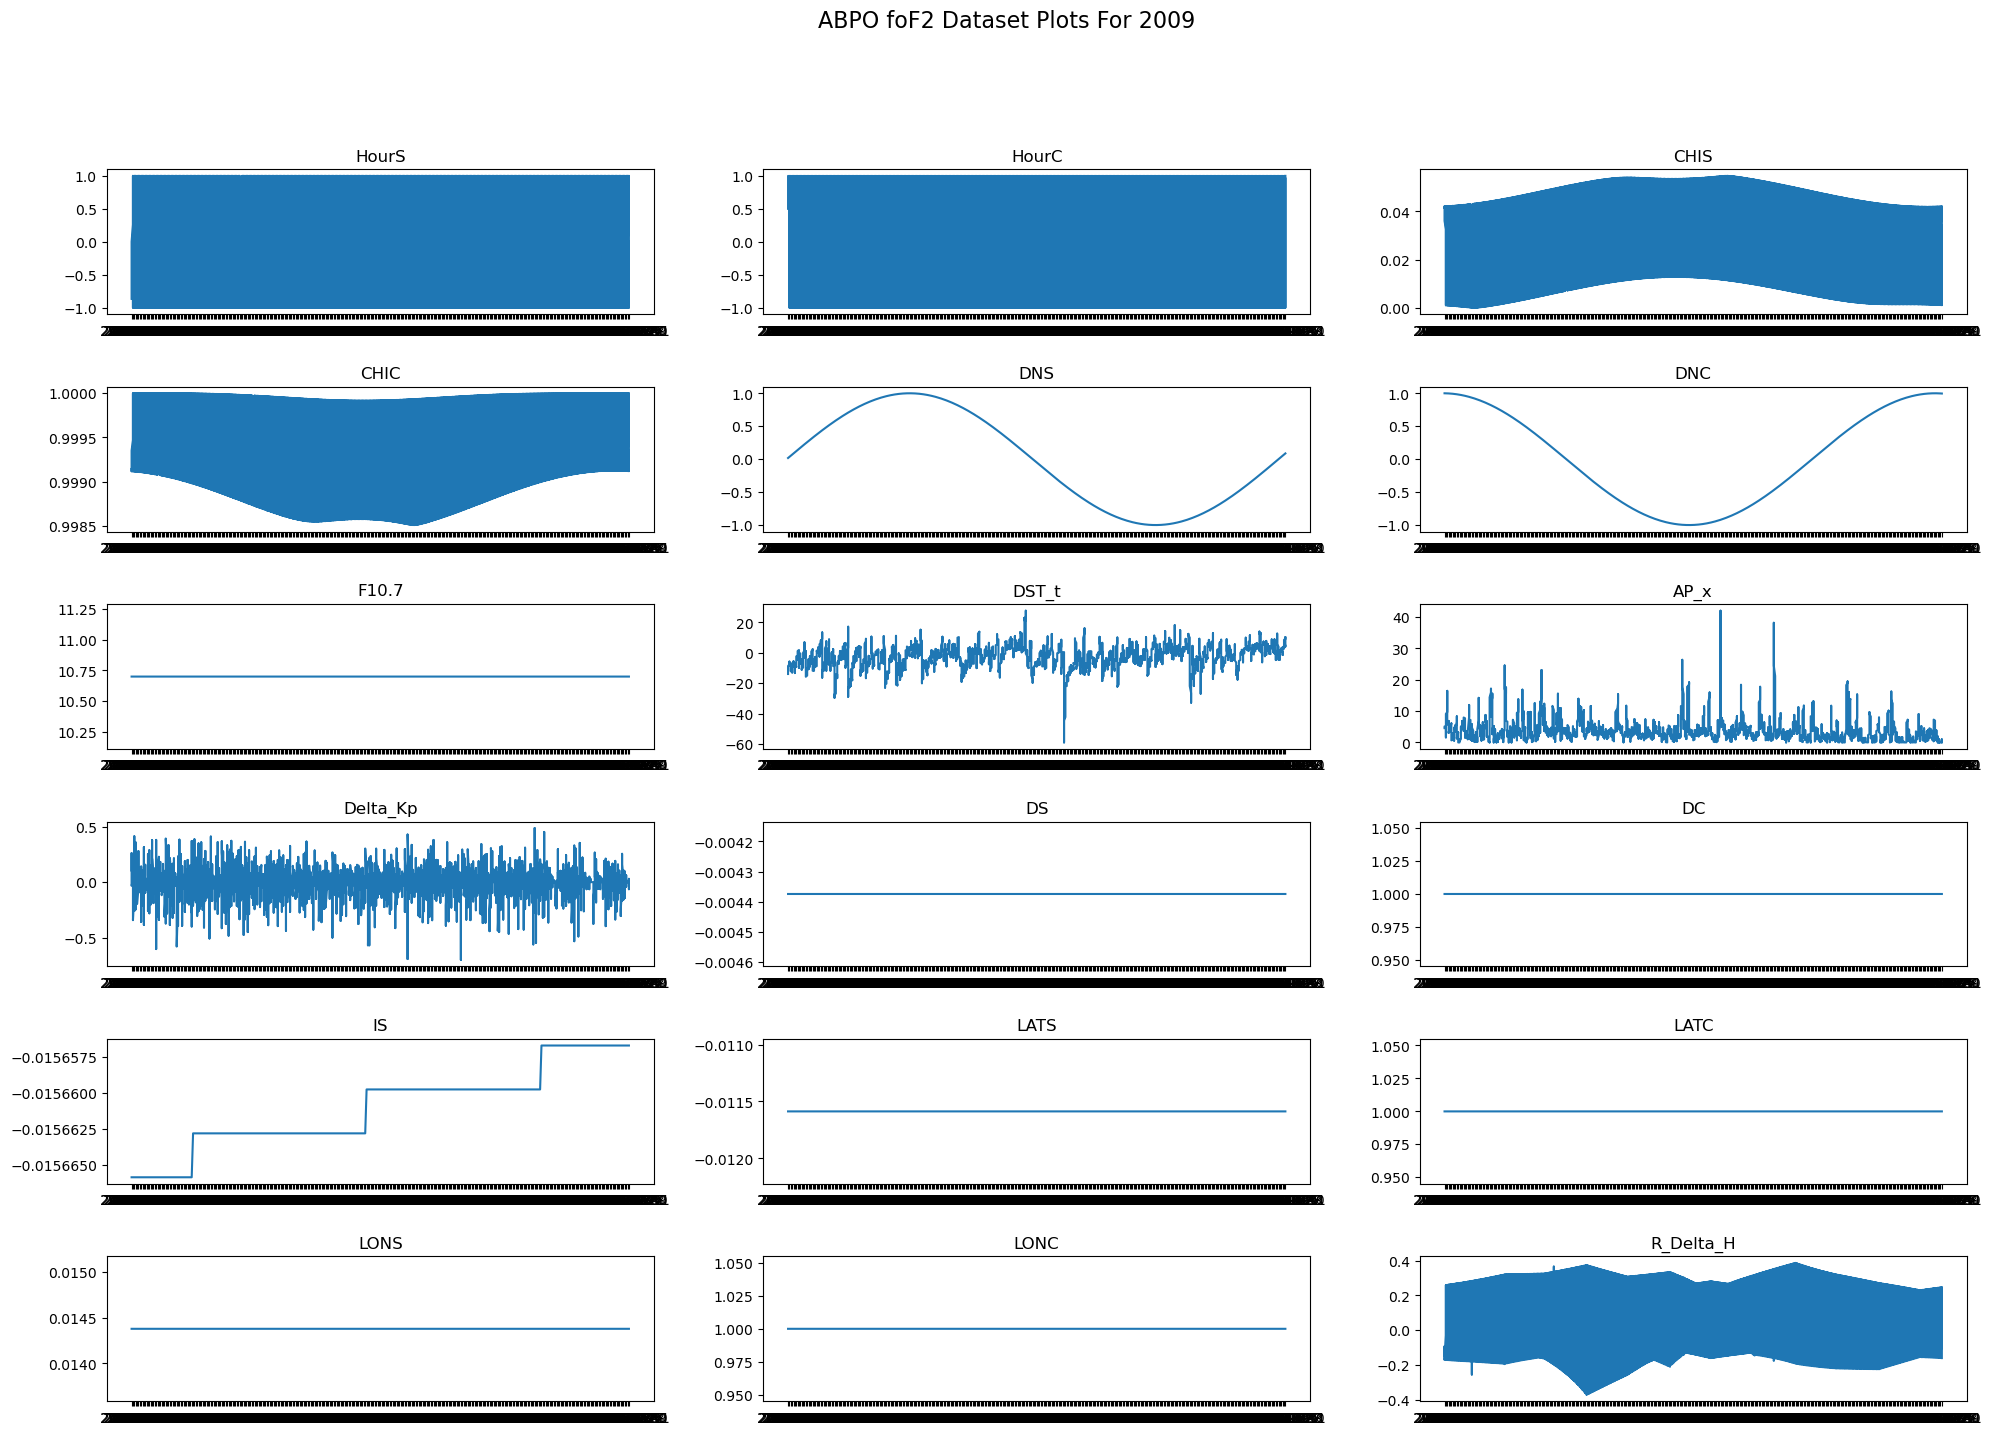

In [12]:
#Plots 6x3 grid for foF2 dataset
#dont forget to iterate with step hour_steps_for_height=39 to see date over time.

colSize=3
rowSize=6

fig, axs = plt.subplots(nrows=rowSize, ncols=colSize, figsize=(24, 16))
fig.suptitle(location+' foF2 Dataset Plots For '+year, fontsize=16)
fig.subplots_adjust(hspace=0.5)

row_index=0
col_index=0

for col in df_foF2.columns[3:-1]:
    axs[row_index, col_index].plot(df_foF2["Date"][::hour_steps_for_height],df_foF2[col][::hour_steps_for_height])
    axs[row_index, col_index].set_title(col)

    col_index+=1

    if col_index==3:
        col_index=0
        row_index+=1

fig.savefig("graphs/"+location+"_"+year+"_foF2_dataset.jpg",dpi=500,bbox_inches='tight')    

In [13]:
# saves foF2 dataframe to the excel file
print(df_foF2.shape)
print(df_foF2.head(10))

df_foF2.to_excel(datafolder+location+year+"_foF2.xlsx",index=False)
df_foF2.to_csv(datafolder+location+year+"_foF2.txt",index=False)


(340665, 22)
       Date  Hour  Height     HourS  HourC      CHIS      CHIC       DNS  \
0  2009-1-1  20.0   100.0 -0.866025    0.5  0.041416  0.999142  0.017452   
1  2009-1-1  20.0   150.0 -0.866025    0.5  0.041416  0.999142  0.017452   
2  2009-1-1  20.0   200.0 -0.866025    0.5  0.041416  0.999142  0.017452   
3  2009-1-1  20.0   250.0 -0.866025    0.5  0.041416  0.999142  0.017452   
4  2009-1-1  20.0   300.0 -0.866025    0.5  0.041416  0.999142  0.017452   
5  2009-1-1  20.0   350.0 -0.866025    0.5  0.041416  0.999142  0.017452   
6  2009-1-1  20.0   400.0 -0.866025    0.5  0.041416  0.999142  0.017452   
7  2009-1-1  20.0   450.0 -0.866025    0.5  0.041416  0.999142  0.017452   
8  2009-1-1  20.0   500.0 -0.866025    0.5  0.041416  0.999142  0.017452   
9  2009-1-1  20.0   550.0 -0.866025    0.5  0.041416  0.999142  0.017452   

        DNC  F10.7  ...  Delta_Kp        DS       DC        IS      LATS  \
0  0.999848   10.7  ...   0.10435 -0.004374  0.99999 -0.015666 -0.011587  